# Variational Autoencoder (VAE) on MNIST

In this tutorial, we implement a **Variational Autoencoder (VAE)** using PyTorch.  
Unlike a standard autoencoder, a VAE does not just learn to reconstruct inputs — it learns a **probabilistic latent space** from which we can both reconstruct inputs *and* generate entirely new data samples.

##### What is a VAE?

A **Variational Autoencoder** is a generative model consisting of:

- **Encoder**: Maps input data to a probability distribution (mean `μ` and log-variance `logσ²`) in the latent space.
- **Reparameterization Trick**: Samples a latent vector `z ~ N(μ, σ²)` in a differentiable way, allowing backpropagation.
- **Decoder**: Generates data by mapping latent vector `z` back to the input space.

Thus, a VAE learns a **continuous, smooth latent space** that captures data variations.

##### Why VAEs?

VAEs are powerful because they allow:
- **Data Generation**: Sample new images by drawing `z` from a standard Gaussian prior.
- **Interpolation**: Smoothly transition between two data points in latent space.
- **Representation Learning**: Latent codes capture meaningful features of the data.
- **Uncertainty Estimation**: Since outputs are probabilistic, VAEs can model uncertainty in data.

##### Architecture in This Notebook

For **MNIST handwritten digits (28×28 grayscale)**:
1. **Encoder**:  
   - Input: 784 pixels → hidden layer (400 units)  
   - Outputs two vectors: mean (`μ`) and log variance (`logσ²`) of latent distribution.  
2. **Latent Space**:  
   - 20-dimensional latent vector `z` sampled using reparameterization trick.  
3. **Decoder**:  
   - Latent vector → hidden layer → reconstructs 784 pixels.  
   - Final activation: Sigmoid (pixel intensities between 0–1).  

##### Training Objective

The VAE loss combines two terms:
1. **Reconstruction Loss**: Binary Cross-Entropy (BCE) between input and output.
2. **KL Divergence**: Regularizes the latent space by pushing the learned distribution towards a standard normal distribution `N(0,1)`.

**Total Loss** = Reconstruction Loss + KL Divergence

##### Steps in This Notebook

1. **Load MNIST dataset**.  
2. **Define VAE model** with encoder, reparameterization, and decoder.  
3. **Train the model** using combined BCE + KL loss.  
4. **Evaluate reconstruction quality** on test data.  
5. **Sample new digits** by drawing from the latent space.  

# Code

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Data Load

In [2]:
def get_mnist_dataloaders(batch_size=64, root="../../data", shuffle_test=False):
    # simple transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize((0.1307,), (0.3081,)),
    ])
    train_dataset = datasets.MNIST(root, train=True, download=True, transform=transform)
    test_dataset  = datasets.MNIST(root, train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_test)
    return train_loader, test_loader

### Variational Autoencoder (VAE) Architecture

In [3]:
class VAE(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=400, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc_mu = nn.Linear(hidden_size, latent_dim)       # mean
        self.fc_logvar = nn.Linear(hidden_size, latent_dim)   # log variance

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_size)
        self.fc3 = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        x = x.view(x.size(0), -1)   # flatten
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x.view(x.size(0), 1, 28, 28), mu, logvar

In [4]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (BCE)
    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence: force latent distribution close to N(0,1)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return bce + kld, bce, kld

### Training

In [5]:
def train(epochs=10, batch_size=128, lr=1e-3, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    train_loader, test_loader = get_mnist_dataloaders(batch_size=batch_size)
    model = VAE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0

        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(data)
            loss, bce, kld = vae_loss(recon, data, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_loss = train_loss / len(train_loader.dataset)
        print(f"Epoch {epoch}: Train Loss={avg_loss:.4f}")

    torch.save(model.state_dict(), "vae.pth")
    print("Model saved to vae.pth")

    return model

In [6]:
model = train(epochs=10, batch_size=128, lr=1e-3)

Using device: cpu
Epoch 1: Train Loss=165.1359
Epoch 2: Train Loss=121.7914
Epoch 3: Train Loss=114.5933
Epoch 4: Train Loss=111.6576
Epoch 5: Train Loss=109.8731
Epoch 6: Train Loss=108.7740
Epoch 7: Train Loss=107.8821
Epoch 8: Train Loss=107.1982
Epoch 9: Train Loss=106.6537
Epoch 10: Train Loss=106.2947
Model saved to vae.pth


### Testing and Visualising Digits

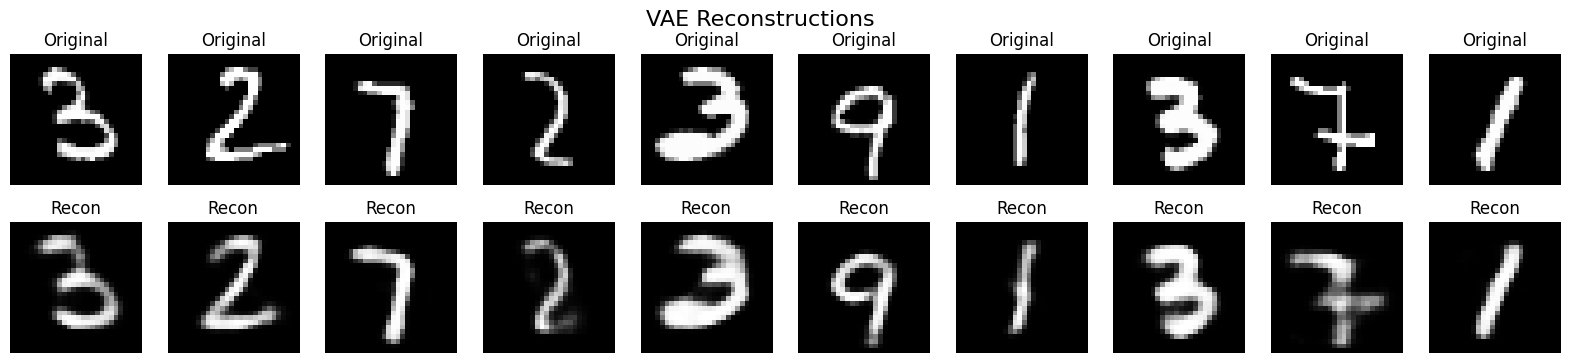

In [13]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE()
model.load_state_dict(torch.load("vae.pth", map_location=device))
model.to(device)
model.eval()

# Reconstruct test images
_, test_loader = get_mnist_dataloaders(batch_size=10, shuffle_test=True)
images, _ = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    recon, mu, logvar = model(images)

# Plot originals vs reconstructions
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(recon[i].cpu().squeeze(), cmap="gray")
    plt.title("Recon")
    plt.axis("off")

plt.suptitle("VAE Reconstructions", fontsize=16)
plt.show()

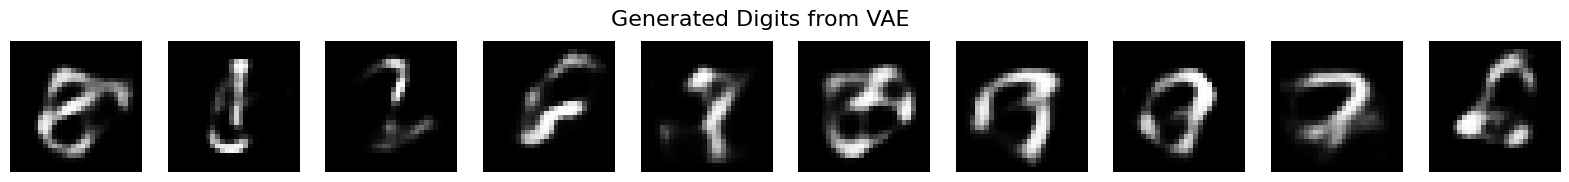

In [16]:
# Sample new digits
with torch.no_grad():
    z = torch.randn(10, 20).to(device)  # 20 = latent_dim
    samples = model.decode(z).view(-1, 1, 28, 28)

plt.figure(figsize=(20, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(samples[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Digits from VAE", fontsize=16)
plt.show()